In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

#dBu = 20log10(V/0.775V)
#The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.
def rfft(x, x_err):
    window = get_window("hanning", len(x))
    x_windowed = x * window
    x_err_windowed = x_err * window
    N = len(x)
    print(f"N = {N}")

    X = fft.rfft(x_windowed)
    X_normalized = np.abs(X) / N
    X_dBu = 20*(np.log10(np.abs(X_normalized)) / 0.775)
    
    X_err = fft.rfft(x_err_windowed)
    X_err_normalized = np.abs(X_err) / N
    X_err_dBu = 20*(X_err_normalized) / (np.log(10) * X_normalized)
    
    return X_dBu, X_err_dBu

#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
def mean_wf(all_amplitudes, error):
    means = np.mean(all_amplitudes, axis=0) #weights are all the same
    weight = 1/error**2
    stds = np.full(len(means), 1/(weight*64)) #64 is the number of wf saved
    return means, stds

In [14]:
hour = '12.14'
day = '290724'

In [28]:
file_pattern = f"{day}_{hour}_wf/wf_{hour}_{day}_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

for i, file in enumerate(file_list):
    df = pd.read_csv(file)
    if i == 0:
        print(df.iloc[:, 0])
        print(df.iloc[:, 1])
        times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
    amplitudes_list.append(amplitudes)
    
#print(amplitudes_list)

all_amplitudes = np.stack(amplitudes_list, axis = 0)

0                (ms)
1          0.00000000
2          0.00100480
3          0.00200960
4          0.00301440
             ...     
99522     99.99869776
99523     99.99970256
99524    100.00070736
99525    100.00171216
99526    100.00271696
Name: Time, Length: 99527, dtype: object
0               (mV)
1         7.87401500
2         7.87401500
3        11.81102000
4         7.87401500
            ...     
99522     7.87401500
99523     3.93700800
99524     7.87401500
99525     7.87401500
99526     7.87401500
Name: Channel A, Length: 99527, dtype: object


In [16]:
LSB = 1/256 #1V / (2**8) = voltage range / number of levels 
error = (0.5)*LSB
amplitudes, errors = mean_wf(all_amplitudes, error)

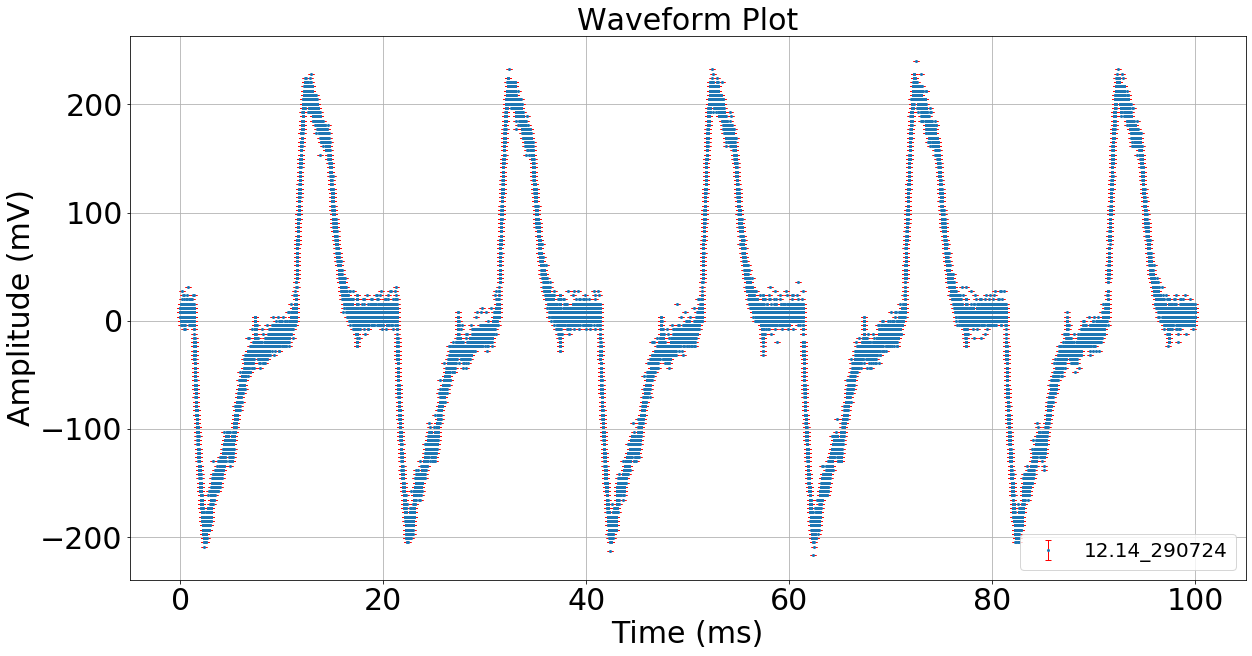

In [17]:
plt.figure(figsize=(20, 10))
plt.errorbar(times, amplitudes, yerr=errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1, label = f"{hour}_{day}")
plt.title('Waveform Plot', fontsize = 30)
plt.xlabel('Time (ms)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude (mV)', fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(loc = "best",  prop={'size': 20})
plt.grid(True)
plt.show()

f_ s = 995.2329599185722
N = 99526


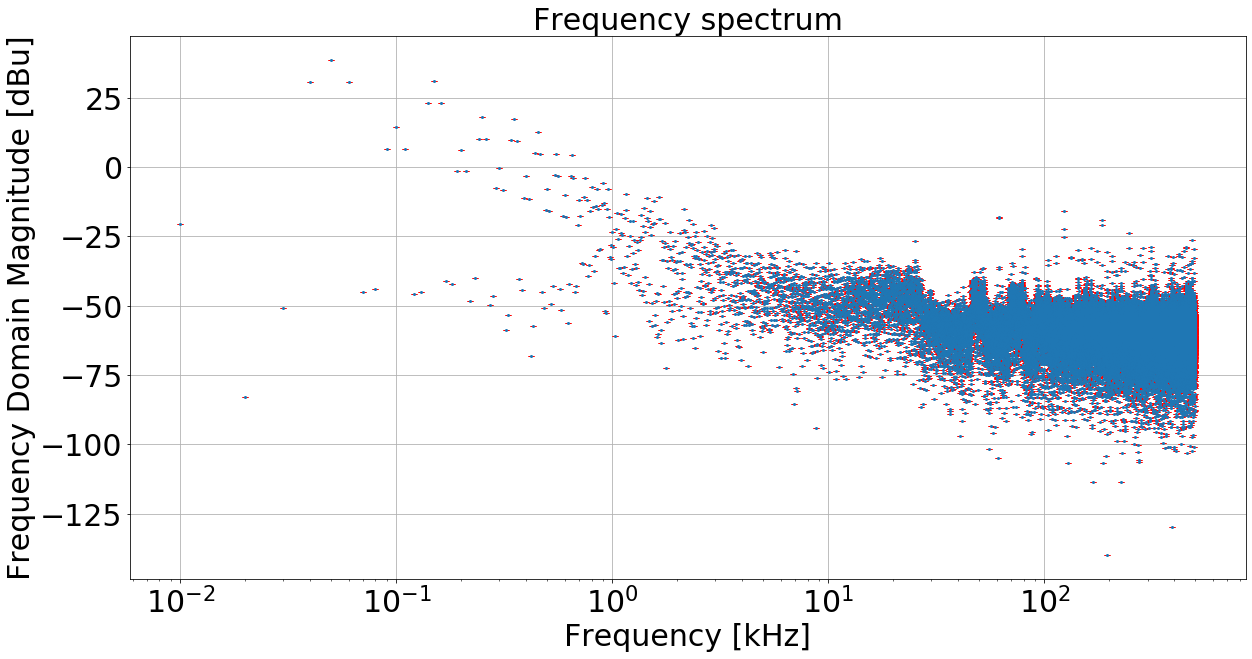

Execution time: 4.027040481567383 seconds


In [31]:
span = times[len(times)-1] 
f_s = len(times) / span
print(f"f_ s = {f_s}")
freqs = fft.rfftfreq(len(amplitudes), 1/f_s) #window lenght, sample spacing

#plot the fft and see how much time it takes
start_time = time.time()

X_dBu, X_err_dBu = rfft(amplitudes, errors)

plt.figure(figsize=(20, 10))
plt.errorbar(freqs, X_dBu, yerr = X_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [kHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogx()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Comaprison with GUI spectrum


In [29]:
df = pd.read_csv(f"{day}_{hour}_fft/fft_{hour}_{day}_01.csv")
print(df.iloc[:, 0])
print(df.iloc[:, 1])
spe = df.to_numpy()
spe = spe[1:]

0               (kHz)
1          0.00000000
2          0.03037179
3          0.06074359
4          0.09111538
             ...     
16380    497.45960978
16381    497.48998158
16382    497.52035337
16383    497.55072516
16384    497.58109696
Name: Frequency, Length: 16385, dtype: object
0               (dBu)
1        -26.24694000
2        -20.90971000
3        -19.98840000
4        -29.66409000
             ...     
16380    -88.32677000
16381    -92.70543000
16382    -93.34309000
16383    -89.13463000
16384    -93.65471000
Name: Channel A, Length: 16385, dtype: object


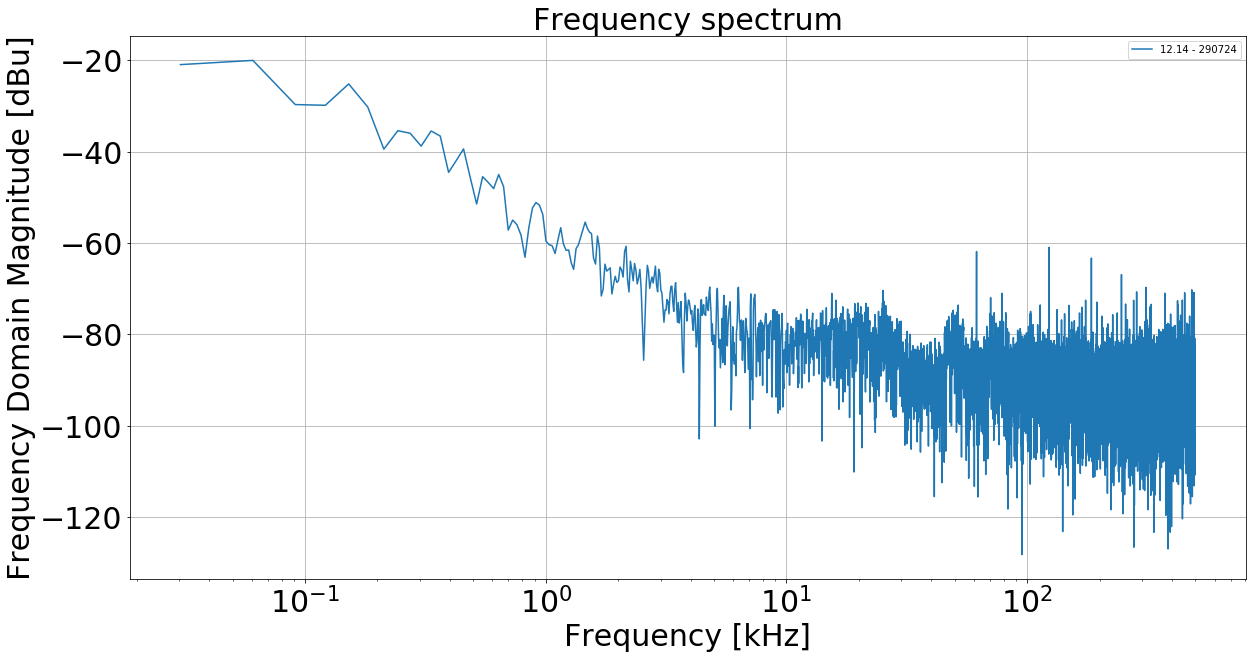

In [30]:
spe_float = spe.astype(float)
frequences = spe_float[1:, 0]

magnitudes = spe_float[1:, 1]

plt.figure(figsize=(20, 10))
plt.plot(frequences, magnitudes, label=f"{hour} - {day}")
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [kHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend()
plt.grid(True)
plt.semilogx()
plt.show()